# Diffusion with dissociation flux

This example is a diffusion problem with one boundary under a dissociation flux (`DissociationFlux`).

The problem is:

$$
\begin{align}
    \nabla \cdot (D \ \nabla{c}) = -S &  \quad \text{on }  \Omega  \\
    c = c_0 & \quad \text{on }  x = 0 \\
    -D \ \nabla c \cdot \mathbf{n} = K_\mathrm{d} \ P & \quad \text{on }  x = 1 \\
\end{align}
$$(problem_fluxes)

The exact solution for mobile concentration is:

$$
\begin{equation}
    c_\mathrm{exact} = 1 + 2 x^2
\end{equation}
$$(c_exact_fluxes)

Injecting {eq}`c_exact_fluxes` in {eq}`problem_fluxes`, we obtain the expressions of $S$, $c_0$, and $K_\mathrm{d}$:

\begin{align}
    & S = -4 D \\
    & c_0 = c_\mathrm{exact}\\
    & P = \frac{4D}{K_\mathrm{d}} 
\end{align}

We can then run a FESTIM model with these values and compare the numerical solution with $c_\mathrm{exact}$.

## FESTIM code

In [38]:
import festim as F
import sympy as sp
import fenics as f
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Create and mark the mesh
nx = ny = 100
fenics_mesh = f.UnitSquareMesh(nx, ny)


volume_markers = f.MeshFunction("size_t", fenics_mesh, fenics_mesh.topology().dim())
volume_markers.set_all(1)

left_surface = f.CompiledSubDomain("near(x[0],  0.0)")
right_surface = f.CompiledSubDomain("near(x[0], 1.0)")
surface_markers = f.MeshFunction(
    "size_t", fenics_mesh, fenics_mesh.topology().dim() - 1
)
surface_markers.set_all(0)
left_surface.mark(surface_markers, 1)
right_surface.mark(surface_markers, 2)

# Create the FESTIM model
my_model = F.Simulation()

my_model.mesh = F.Mesh(
    fenics_mesh, volume_markers=volume_markers, surface_markers=surface_markers
)

# Variational formulation
exact_solution = 10 + 2 * F.x**2  # exact solution

D = 20
K_d = 10

my_model.sources = [F.Source(-4 * D, volume=1, field="solute")]

my_model.boundary_conditions = [
    F.DirichletBC(surfaces=[1], value=exact_solution, field="solute"),
    F.DissociationFlux(surfaces=[2], Kd_0=K_d, E_Kd=0, P=4 * D / K_d),
]

my_model.materials = F.Material(id=1, D_0=D, E_D=0)

my_model.T = F.Temperature(500)  # ignored in this problem

my_model.settings = F.Settings(
    absolute_tolerance=1e-10,
    relative_tolerance=1e-10,
    transient=False,
)

my_model.initialise()
my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.60 s


## Comparison with exact solution

L2 error: 3.55e-05


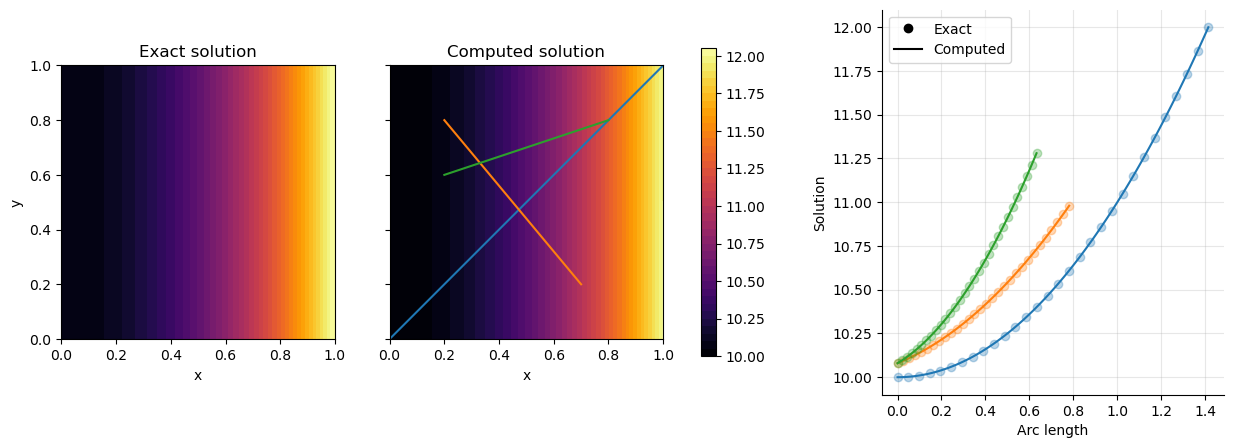

In [39]:
c_exact = f.Expression(sp.printing.ccode(exact_solution), degree=4)
c_exact = f.project(c_exact, f.FunctionSpace(my_model.mesh.mesh, "CG", 1))

computed_solution = my_model.h_transport_problem.mobile.post_processing_solution
E = f.errornorm(computed_solution, c_exact, "L2")
print(f"L2 error: {E:.2e}")

# plot exact solution and computed solution
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.sca(axs[0])
plt.title("Exact solution")
plt.xlabel("x")
plt.ylabel("y")
CS1 = f.plot(c_exact, cmap="inferno")
plt.sca(axs[1])
plt.xlabel("x")
plt.title("Computed solution")
CS2 = f.plot(computed_solution, cmap="inferno")

plt.colorbar(CS2, ax=[axs[0], axs[1]], shrink=0.8)

axs[0].sharey(axs[1])
plt.setp(axs[1].get_yticklabels(), visible=False)

for CS in [CS1, CS2]:
    CS.set_edgecolor("face")


def compute_arc_length(xs, ys):
    """Computes the arc length of x,y points based
    on x and y arrays
    """
    points = np.vstack((xs, ys)).T
    distance = np.linalg.norm(points[1:] - points[:-1], axis=1)
    arc_length = np.insert(np.cumsum(distance), 0, [0.0])
    return arc_length


# define the profiles
profiles = [
    {"start": (0.0, 0.0), "end": (1.0, 1.0)},
    {"start": (0.2, 0.8), "end": (0.7, 0.2)},
    {"start": (0.2, 0.6), "end": (0.8, 0.8)},
]

# plot the profiles on the right subplot
for i, profile in enumerate(profiles):
    start_x, start_y = profile["start"]
    end_x, end_y = profile["end"]
    plt.sca(axs[1])
    (l,) = plt.plot([start_x, end_x], [start_y, end_y])

    plt.sca(axs[2])

    points_x_exact = np.linspace(start_x, end_x, num=30)
    points_y_exact = np.linspace(start_y, end_y, num=30)
    arc_length_exact = compute_arc_length(points_x_exact, points_y_exact)
    u_values = [c_exact(x, y) for x, y in zip(points_x_exact, points_y_exact)]

    points_x = np.linspace(start_x, end_x, num=100)
    points_y = np.linspace(start_y, end_y, num=100)
    arc_lengths = compute_arc_length(points_x, points_y)
    computed_values = [computed_solution(x, y) for x, y in zip(points_x, points_y)]

    (exact_line,) = plt.plot(
        arc_length_exact, u_values, color=l.get_color(), marker="o", linestyle="None", alpha=0.3
    )
    (computed_line,) = plt.plot(arc_lengths, computed_values, color=l.get_color())

plt.sca(axs[2])
plt.xlabel("Arc length")
plt.ylabel("Solution")

legend_marker = mpl.lines.Line2D(
    [],
    [],
    color="black",
    marker=exact_line.get_marker(),
    linestyle="None",
    label="Exact",
)
legend_line = mpl.lines.Line2D([], [], color="black", label="Computed")
plt.legend(
    [legend_marker, legend_line], [legend_marker.get_label(), legend_line.get_label()]
)

plt.grid(alpha=0.3)
plt.gca().spines[["right", "top"]].set_visible(False)
for ext in ["png", "svg", "pdf"]:
    plt.savefig(f"mms_fluxes.{ext}")
plt.show()


## Compute convergence rates

It is also possible to compute how the numerical error decreases as we increase the number of cells.
By iteratively refining the mesh, we find that the error exhibits a second order convergence rate.
This is expected for this particular problem as first order finite elements are used.

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.20 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.50 s
Defining initial values
Defining v

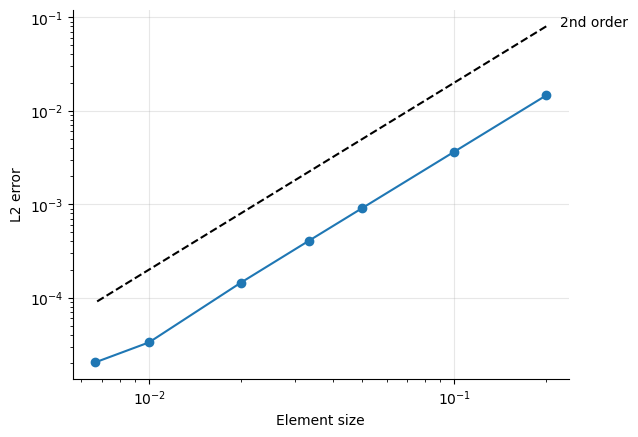

In [40]:
errors = []
ns = [5, 10, 20, 30, 50, 100, 150]

for n in ns:
    nx = ny = n
    fenics_mesh = f.UnitSquareMesh(nx, ny)

    volume_markers = f.MeshFunction("size_t", fenics_mesh, fenics_mesh.topology().dim())
    volume_markers.set_all(1)

    surface_markers = f.MeshFunction(
        "size_t", fenics_mesh, fenics_mesh.topology().dim() - 1
    )
    surface_markers.set_all(1)

    my_model.mesh = F.Mesh(
        fenics_mesh, volume_markers=volume_markers, surface_markers=surface_markers
    )

    my_model.initialise()
    my_model.run()
    
    computed_solution = my_model.h_transport_problem.mobile.post_processing_solution
    errors.append(f.errornorm(computed_solution, c_exact, "L2"))

h = 1 / np.array(ns)

plt.loglog(h, errors, marker="o")
plt.xlabel("Element size")
plt.ylabel("L2 error")

plt.loglog(h, 2 * h**2, linestyle="--", color="black")
plt.annotate("2nd order", (h[0], 2 * h[0]**2), textcoords="offset points", xytext=(10, 0))

plt.grid(alpha=0.3)
plt.gca().spines[["right", "top"]].set_visible(False)
